In [1]:
import os
from pathlib import Path
os.chdir("/Users/mregan/Dev/Litmus-freqtrade-temp/")
print(Path.cwd())

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%load_ext autoreload
%autoreload 2

/Users/mregan/Dev/Litmus-freqtrade-temp


In [2]:
import pandas as pd
import numpy as np

from user_data.litmus import get_labeled_data
from user_data.litmus import meta_model

pd.options.display.max_columns = 400
pd.options.display.max_rows = 400

In [3]:
ld = get_labeled_data.GetLabeledData(
    timeframe='12h',
    latest=False,
    bt_filename='backtest_vulcanprimary-2022-05-06_21-50-16.json',
    bt_pkl_filename='backtest_vulcanprimary-2022-05-06_21-50-16_signals.pkl')

In [4]:
df = ld.get_all_data()
df

open    high     low  \
strategy      pair       date                                                
VulcanPrimary 1INCH/USDT 2021-03-08 12:00:00+00:00  3.9949  4.4662  3.9887   
                         2021-03-17 00:00:00+00:00  4.5603  4.8100  4.2512   
                         2021-04-04 12:00:00+00:00  4.3702  4.7020  4.3340   
                         2021-04-13 12:00:00+00:00  5.4557  5.7313  5.4438   
                         2021-04-30 12:00:00+00:00  5.5725  5.6900  5.5086   
...                                                    ...     ...     ...   
              ZRX/USDT   2021-12-24 12:00:00+00:00  0.8718  0.8989  0.8416   
                         2022-01-01 12:00:00+00:00  0.8298  0.8759  0.8296   
                         2022-02-03 00:00:00+00:00  0.5715  0.5953  0.5686   
                         2022-02-16 00:00:00+00:00  0.6417  0.6948  0.6300   
                         2022-03-17 00:00:00+00:00  0.5110  0.5144  0.5028   

                                                     close       volume  \
strategy      pair       date                                             
VulcanPrimary 1INCH/USDT 2021-03-08 12:00:00+00:00  4.3249  10997902.63   
                         2021-03-17 00:00:00+00:00  4.4766  10717840.77   
                         2021-04-04 12:00:00+00:00  4.5700   3971927.19   
                         2021-04-13 12:00:00+00:00  5.6116   4272484.89   
                         2021-04-30 12:00:00+00:00  5.6400   3289967.31   
...                                                    ...          ...   
              ZRX/USDT   2021-12-24 12:00:00+00:00  0.8497   2260901.00   
                         2022-01-01 12:00:00+00:00  0.8748   1954741.00   
                         2022-02-03 00:00:00+00:00  0.5944   2726652.00   
                         2022-02-16 00:00:00+00:00  0.6811   5635380.00   
                         2022-03-17 00:00:00+00:00  0.5116   1133797.00   

                                                      volume_adi  \
strategy      pair       date                                      
VulcanPrimary 1INCH/USDT 2021-03-08 12:00:00+00:00  8.774016e+07   
                         2021-03-17 00:00:00+00:00  9.390124e+07   
                         2021-04-04 12:00:00+00:00  9.185711e+07   
                         2021-04-13 12:00:00+00:00  1.166959e+08   
                         2021-04-30 12:00:00+00:00  1.404404e+08   
...                                                          ...   
              ZRX/USDT   2021-12-24 12:00:00+00:00  7.841945e+07   
                         2022-01-01 12:00:00+00:00  7.991118e+07   
                         2022-02-03 00:00:00+00:00  7.528651e+07   
                         2022-02-16 00:00:00+00:00  8.687536e+07   
                         2022-03-17 00:00:00+00:00  8.268237e+07   

                                                      volume_obv  volume_cmf  \
strategy      pair       date                                                  
VulcanPrimary 1INCH/USDT 2021-03-08 12:00:00+00:00  4.732082e+05    0.034775   
                         2021-03-17 00:00:00+00:00 -1.446079e+07    0.093779   
                         2021-04-04 12:00:00+00:00 -2.110222e+07    0.173375   
                         2021-04-13 12:00:00+00:00 -7.370963e+06    0.149558   
                         2021-04-30 12:00:00+00:00  1.717377e+07    0.175899   
...                                                          ...         ...   
              ZRX/USDT   2021-12-24 12:00:00+00:00  9.503496e+08    0.168347   
                         2022-01-01 12:00:00+00:00  9.534915e+08    0.031506   
                         2022-02-03 00:00:00+00:00  9.046713e+08    0.076853   
                         2022-02-16 00:00:00+00:00  9.299385e+08    0.148932   
                         2022-03-17 00:00:00+00:00  9.537537e+08    0.240490   

                                                        volume_fi  volume_em  \
strategy      pair       date                            

In [5]:
df['exit_reason'].value_counts()

lower_barrier_sl_sell          4203
upper_barrier_pt_sell          3667
vertical_barrier_force_sell    2791
force_exit                      701
Name: exit_reason, dtype: int64

In [6]:
# Tripple barrier target setting method

tbm_target = 'upper_based'

if tbm_target == 'upper_based':
    df['y_true'] = np.nan
    df['y_true'] = np.where(df['exit_reason'].isin(['upper_barrier_pt_sell']), True, df['y_true'])
    df['y_true'] = np.where(df['exit_reason'].isin(['lower_barrier_sl_sell', 'vertical_barrier_force_sell']), False, df['y_true'])
    df['y_true'] = np.where(df['exit_reason'].isin(['force_exit']), np.nan, df['y_true'])

elif tbm_target == 'sign_based':
    df['y_true'] = np.nan
    df['y_true'] = np.where(df['profit_ratio'] > 0, True, df['y_true'])
    df['y_true'] = np.where(df['profit_ratio'] <= 0, False, df['y_true'])
    df['y_true'] = np.where(df['exit_reason'].isin(['force_exit']), np.nan, df['y_true'])
    
df['y_true'].value_counts()

0.0    6994
1.0    3667
Name: y_true, dtype: int64

In [7]:
df['y_pred'] = True

In [8]:
#df['pair_copy'] = 'Dummy Pair'

In [9]:
# Train ML model to predict 'correct_trade'

pair_only_features = [
       'volume_cmf', 'volume_fi', 'volume_em',
       'volume_sma_em', 'volume_vpt',  'volume_mfi',
       'volatility_bbw', 'volatility_bbp',  'volatility_kcw', 'volatility_kcp',
       'volatility_dcw',
       'volatility_dcp', 'volatility_ui', 'trend_macd_diff', 
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg',
       'trend_vortex_ind_diff', 'trend_mass_index',
       'trend_dpo', 'trend_kst_diff',
       'trend_stc', 'trend_adx', 'trend_adx_pos',
       'trend_adx_neg', 'trend_cci', 'trend_aroon_up', 'trend_aroon_down',
       'trend_aroon_ind',
       'momentum_rsi', 'momentum_stoch_rsi', 'momentum_stoch_rsi_k',
       'momentum_stoch_rsi_d', 'momentum_tsi', 'momentum_uo',
       'momentum_stoch', 'momentum_stoch_signal', 'momentum_wr',
       'momentum_roc', 'momentum_ppo',
       'momentum_ppo_signal', 'momentum_ppo_hist', 'momentum_pvo',
       'momentum_pvo_signal', 'momentum_pvo_hist',
       'others_dr', 'others_dlr']

btc = ['volume_cmf_btc_12h', 'volume_fi_btc_12h', 'volume_em_btc_12h', 'volume_vpt_btc_12h',
        'volume_mfi_btc_12h',
       'volatility_bbw_btc_12h',
       'volatility_bbp_btc_12h',
       'volatility_kcw_btc_12h', 'volatility_kcp_btc_12h', 'volatility_dcw_btc_12h',
       'volatility_dcp_btc_12h',
       'volatility_ui_btc_12h', 'trend_macd_btc_12h',
       'trend_macd_diff_btc_12h',
       'trend_vortex_ind_pos_btc_12h', 'trend_vortex_ind_neg_btc_12h',
       'trend_vortex_ind_diff_btc_12h', 'trend_trix_btc_12h',
       'trend_mass_index_btc_12h', 'trend_dpo_btc_12h',
       'trend_kst_btc_12h', 'trend_kst_sig_btc_12h',
       'trend_kst_diff_btc_12h', 'trend_stc_btc_12h',
       'trend_adx_btc_12h', 'trend_adx_pos_btc_12h',
       'trend_adx_neg_btc_12h', 'trend_cci_btc_12h',
       'trend_aroon_up_btc_12h',
       'trend_aroon_down_btc_12h', 'trend_aroon_ind_btc_12h',
       'momentum_rsi_btc_12h',
       'momentum_stoch_rsi_btc_12h', 'momentum_stoch_rsi_k_btc_12h',
       'momentum_stoch_rsi_d_btc_12h', 'momentum_tsi_btc_12h',
       'momentum_uo_btc_12h', 'momentum_stoch_btc_12h',
       'momentum_stoch_signal_btc_12h', 'momentum_wr_btc_12h',
       'momentum_ao_btc_12h', 'momentum_roc_btc_12h',
       'momentum_ppo_btc_12h',
       'momentum_ppo_hist_btc_12h', 'momentum_pvo_btc_12h',
       'momentum_pvo_signal_btc_12h', 'momentum_pvo_hist_btc_12h',
       'others_dr_btc_12h', 'others_dlr_btc_12h']

spx = [
       'volume_spx_1d',
       'volume_cmf_spx_1d', 'volume_fi_spx_1d', 'volume_em_spx_1d',
       'volume_sma_em_spx_1d', 'volume_vpt_spx_1d',
       'volume_mfi_spx_1d',
       'volatility_bbw_spx_1d',
       'volatility_bbp_spx_1d',
       'volatility_kcw_spx_1d', 'volatility_kcp_spx_1d', 'volatility_dcw_spx_1d',
       'volatility_dcp_spx_1d', 'volatility_atr_spx_1d',
       'volatility_ui_spx_1d', 'trend_macd_spx_1d',
       'trend_macd_signal_spx_1d', 'trend_macd_diff_spx_1d',
       'trend_vortex_ind_pos_spx_1d', 'trend_vortex_ind_neg_spx_1d',
       'trend_vortex_ind_diff_spx_1d', 'trend_trix_spx_1d',
       'trend_mass_index_spx_1d', 'trend_dpo_spx_1d',
       'trend_kst_spx_1d', 'trend_kst_sig_spx_1d',
       'trend_kst_diff_spx_1d', 'trend_stc_spx_1d',
       'trend_adx_spx_1d', 'trend_adx_pos_spx_1d',
       'trend_adx_neg_spx_1d', 'trend_cci_spx_1d',
       'trend_aroon_up_spx_1d',
       'trend_aroon_down_spx_1d', 'trend_aroon_ind_spx_1d',
       'momentum_rsi_spx_1d',
       'momentum_stoch_rsi_spx_1d', 'momentum_stoch_rsi_k_spx_1d',
       'momentum_stoch_rsi_d_spx_1d', 'momentum_tsi_spx_1d',
       'momentum_uo_spx_1d', 'momentum_stoch_spx_1d',
       'momentum_stoch_signal_spx_1d', 'momentum_wr_spx_1d',
       'momentum_ao_spx_1d', 'momentum_roc_spx_1d',
       'momentum_ppo_spx_1d', 'momentum_ppo_signal_spx_1d',
       'momentum_ppo_hist_spx_1d', 'momentum_pvo_spx_1d',
       'momentum_pvo_signal_spx_1d', 'momentum_pvo_hist_spx_1d',
        'others_dr_spx_1d', 'others_dlr_spx_1d']

vix = [
       'volatility_bbw_vix_1d',
       'volatility_bbp_vix_1d',
       'volatility_kcw_vix_1d', 'volatility_kcp_vix_1d', 'volatility_dcw_vix_1d',
       'volatility_dcp_vix_1d', 'volatility_atr_vix_1d',
       'volatility_ui_vix_1d', 'trend_macd_vix_1d',
       'trend_macd_signal_vix_1d', 'trend_macd_diff_vix_1d',
       'trend_vortex_ind_pos_vix_1d', 'trend_vortex_ind_neg_vix_1d',
       'trend_vortex_ind_diff_vix_1d', 'trend_trix_vix_1d',
       'trend_mass_index_vix_1d', 'trend_dpo_vix_1d',
       'trend_kst_vix_1d', 'trend_kst_sig_vix_1d',
       'trend_kst_diff_vix_1d', 'trend_stc_vix_1d',
       'trend_adx_vix_1d', 'trend_adx_pos_vix_1d',
       'trend_adx_neg_vix_1d', 'trend_cci_vix_1d',
       'trend_aroon_up_vix_1d',
       'trend_aroon_down_vix_1d', 'trend_aroon_ind_vix_1d',
       'momentum_rsi_vix_1d',
       'momentum_stoch_rsi_vix_1d', 'momentum_stoch_rsi_k_vix_1d',
       'momentum_stoch_rsi_d_vix_1d', 'momentum_tsi_vix_1d',
       'momentum_uo_vix_1d', 'momentum_stoch_vix_1d',
       'momentum_stoch_signal_vix_1d', 'momentum_wr_vix_1d',
       'momentum_ao_vix_1d', 'momentum_roc_vix_1d',
       'momentum_ppo_vix_1d', 'momentum_ppo_signal_vix_1d',
       'momentum_ppo_hist_vix_1d',
        'others_dr_vix_1d', 'others_dlr_vix_1d']

dxy = [
       'volatility_bbw_dxy_1d',
       'volatility_bbp_dxy_1d',
       'volatility_kcw_dxy_1d', 'volatility_kcp_dxy_1d', 'volatility_dcw_dxy_1d',
       'volatility_dcp_dxy_1d', 'volatility_atr_dxy_1d',
       'volatility_ui_dxy_1d', 'trend_macd_dxy_1d',
       'trend_macd_signal_dxy_1d', 'trend_macd_diff_dxy_1d',
       'trend_vortex_ind_pos_dxy_1d', 'trend_vortex_ind_neg_dxy_1d',
       'trend_vortex_ind_diff_dxy_1d', 'trend_trix_dxy_1d',
       'trend_mass_index_dxy_1d', 'trend_dpo_dxy_1d',
       'trend_kst_dxy_1d', 'trend_kst_sig_dxy_1d',
       'trend_kst_diff_dxy_1d', 'trend_stc_dxy_1d',
       'trend_adx_dxy_1d', 'trend_adx_pos_dxy_1d',
       'trend_adx_neg_dxy_1d', 'trend_cci_dxy_1d',
       'trend_aroon_up_dxy_1d',
       'trend_aroon_down_dxy_1d', 'trend_aroon_ind_dxy_1d',
       'momentum_rsi_dxy_1d',
       'momentum_stoch_rsi_dxy_1d', 'momentum_stoch_rsi_k_dxy_1d',
       'momentum_stoch_rsi_d_dxy_1d', 'momentum_tsi_dxy_1d',
       'momentum_uo_dxy_1d', 'momentum_stoch_dxy_1d',
       'momentum_stoch_signal_dxy_1d', 'momentum_wr_dxy_1d',
       'momentum_ao_dxy_1d', 'momentum_roc_dxy_1d',
       'momentum_ppo_dxy_1d', 'momentum_ppo_signal_dxy_1d',
       'momentum_ppo_hist_dxy_1d',
        'others_dr_dxy_1d', 'others_dlr_dxy_1d']

best = ['volume_cmf',
 'volume_fi', 'volume_vpt',
 'trend_vortex_ind_neg', 'trend_stc',
 'trend_cci', 'momentum_stoch_rsi_d',
 'momentum_tsi', 'momentum_stoch_signal',
 'volume_cmf_btc_12h', 'trend_macd_diff_btc_12h',
 'trend_vortex_ind_neg_btc_12h',
 'trend_kst_diff_btc_12h', 'trend_aroon_down_btc_12h',
 'momentum_stoch_rsi_btc_12h', 'momentum_roc_btc_12h',
 'volume_spx_1d', 'volume_mfi_spx_1d',
 'trend_kst_diff_spx_1d', 'trend_aroon_up_spx_1d',
 'trend_aroon_down_spx_1d', 'trend_aroon_ind_spx_1d',
 'momentum_uo_spx_1d', 'momentum_stoch_signal_spx_1d',
 'momentum_ppo_hist_spx_1d', 'others_dr_spx_1d',
 'volatility_kcw_vix_1d', 'volatility_dcp_vix_1d',
 'volatility_atr_vix_1d',
 'trend_vortex_ind_pos_vix_1d', 'trend_kst_vix_1d',
 'trend_kst_sig_vix_1d', 'trend_adx_vix_1d',
 'trend_aroon_down_vix_1d',
 'momentum_stoch_signal_vix_1d', 'momentum_ao_vix_1d',
 'trend_mass_index_dxy_1d', 'trend_stc_dxy_1d',
 'trend_aroon_up_dxy_1d']

all_features = pair_only_features + btc + spx + vix + dxy

In [10]:
# Drop BTC

df = df.drop('BTC/USDT', level='pair', axis=0)

In [11]:
# Limit training data so we can backest with holdout
idx = pd.IndexSlice

model = meta_model.MetaModel(data=df.loc[idx[:, :, :'2021-06-01']], 
                     X_features_num=best,
                     X_features_cat=['pair_copy'],
                     y_pred_col='y_pred', 
                     y_true_col='y_true',
                     sample_weight_col='profit_ratio')

In [12]:
model.check_data()

No NaNs found in the DataFrame. Ready to train meta model.


In [13]:
model.clean_data()

Removed 0 NaN / Infinity observations from DataFrame


In [14]:
model.classification_report(model='primary')

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3687
         1.0       0.41      1.00      0.58      2549

    accuracy                           0.41      6236
   macro avg       0.20      0.50      0.29      6236
weighted avg       0.17      0.41      0.24      6236



In [15]:
model.run_cross_validation(cv_n_splits=6, cv_gap=40)

Train: 2017-10-06 2019-11-11 Test: 2019-12-03 2020-05-13
Train: 2019-10-09 2020-05-07 Test: 2020-05-14 2020-08-29
Train: 2020-04-22 2020-08-20 Test: 2020-08-29 2020-12-09
Train: 2020-08-06 2020-12-04 Test: 2020-12-09 2021-02-02
Train: 2020-11-24 2021-02-01 Test: 2021-02-02 2021-03-30
Train: 2021-01-24 2021-03-28 Test: 2021-03-30 2021-06-01


In [16]:
model.classification_report(model='meta')

              precision    recall  f1-score   support

         0.0       0.54      0.69      0.60      2924
         1.0       0.43      0.28      0.34      2416

    accuracy                           0.50      5340
   macro avg       0.48      0.48      0.47      5340
weighted avg       0.49      0.50      0.48      5340



In [ ]:
model.get_most_important_features(cv_n_splits=3, cv_gap=40, cv_sample=1)

In [ ]:
model.plot_feature_selection(figsize=(50, 8))

In [ ]:
best_features_df = pd.DataFrame.from_dict(model.clf.named_steps['feature_selection'].get_metric_dict()).T
best_features_df

In [ ]:
top_features = []
prev_features = []

for k, v in model.clf.named_steps['feature_selection'].subsets_.items():
    current_features = list(v['feature_idx'])
    current_features = [i for i in current_features if i not in prev_features]
    top_features += current_features
    prev_features = list(v['feature_idx'])
    
ranked_top_features = model.X_transformed_features[[top_features]]
ranked_top_features

In [ ]:
[f for f in ranked_top_features if 'onehotencoder__' not in f]

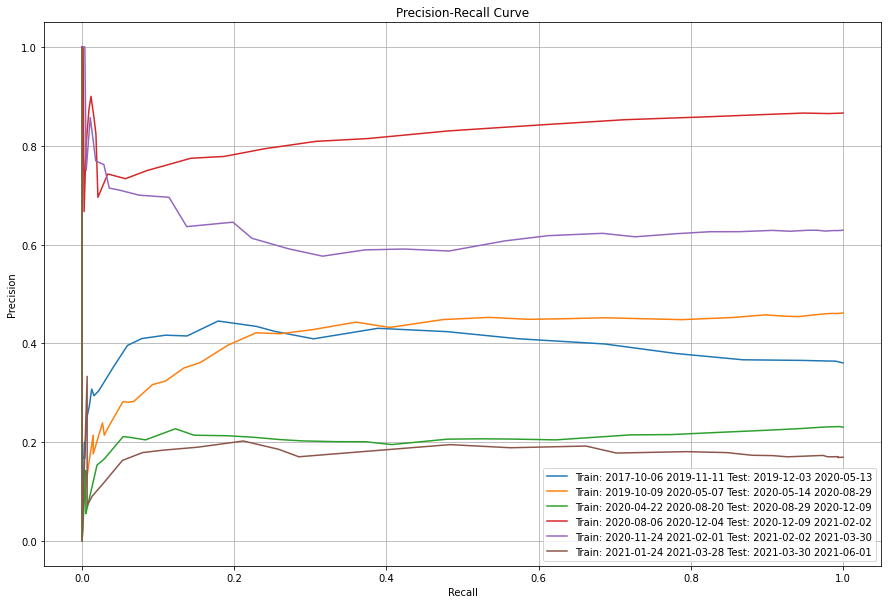

In [17]:
model.plot_precision_recall_curve()

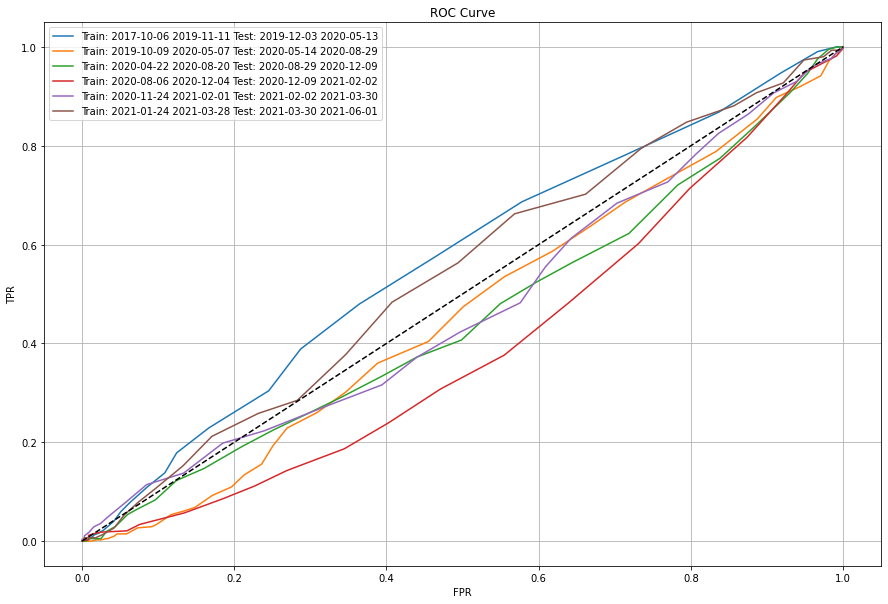

In [18]:
model.plot_roc_curve()

In [ ]:
model.plot_feature_importance()

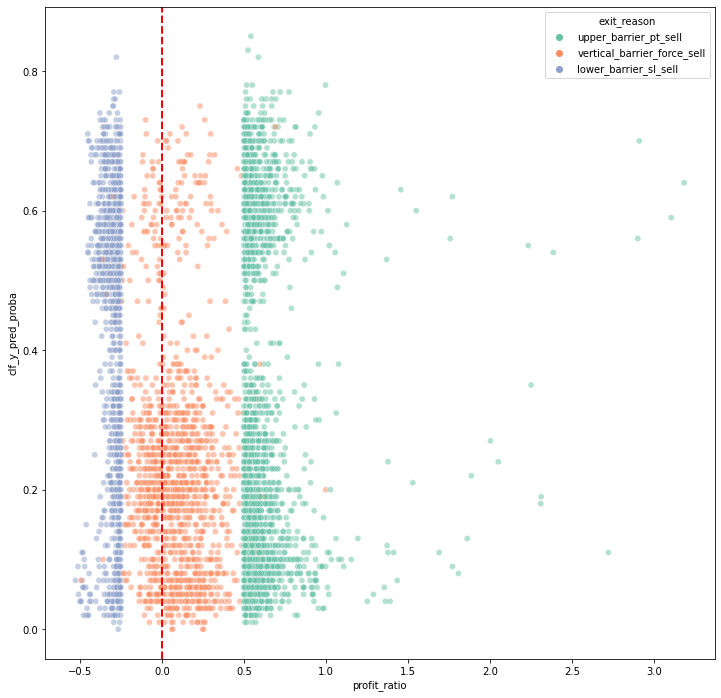

In [20]:
model.plot_probability_returns_scatter()

In [ ]:
model.probability_returns_table()

In [ ]:
model.run_train_on_more_data(date_from='2021-01-01')

In [ ]:
model.plot_feature_importance()

In [ ]:
model.model_threshold_table()

In [ ]:
model.set_model_threshold(model_threshold=0.5)

In [ ]:
model.save_model(filename='VulcanMeta.pkl')

# Appendix / Testing (to be deleted)

In [ ]:
idx = pd.IndexSlice

model.data['clf_y_pred_proba'].sort_index(level='date').plot(figsize=(15, 7))
model.data.loc[idx[:, 'ETH/USDT', :]]['profit_ratio'].sort_index(level='date').plot(secondary_y=True)


In [ ]:
feature_names_out = model.clf['full_transformer']['column_transformer'].get_feature_names_out()
feature_names_out

In [ ]:
transformed_data = model.clf['full_transformer'].transform(model.X_test)
transformed_data

In [ ]:
features_out_df = pd.DataFrame(transformed_data, columns=feature_names_out)
features_out_df

In [ ]:
features_out_df.plot(subplots=True, figsize=(10, 400))

In [ ]:
model.X_test.plot(subplots=True, figsize=(10, 400))

In [ ]:
fracdiff_coeff = model.clf['full_transformer']['column_transformer'].transformers_[1][1].d_
fracdiff_coeff

In [ ]:
import fracdiff

In [ ]:
ff = fracdiff.sklearn.FracdiffStat()

In [ ]:
ff.fit(model.X_test['momentum_ppo_hist_btc_12h'].values.reshape(-1, 1))

In [ ]:
model.X_test['momentum_ppo_hist_btc_12h'].plot()

In [ ]:
ff.d_

In [ ]:
model.clf.named_steps['column_transformer'].get_feature_names_out()

In [ ]:
model.roc_stats